In [1]:
from datetime import datetime, timedelta
from io import BytesIO
from pandas import read_csv
from shapefile import Reader
import requests
import geopandas

In [2]:
datamart = "https://dd.weather.gc.ca"
stations = read_csv(f"{datamart}/hydrometric/doc/hydrometric_StationList.csv")

In [4]:
def hydrometric(station, freq='hourly'):
    id, prov_terr = station[' ID'], station['Prov/Terr']
    return read_csv(f"{datamart}/hydrometric/csv/{prov_terr}/{freq}/{prov_terr}_{id}_{freq}_hydrometric.csv")

In [13]:
def hrdpa_watershed(accum_period=6):
    def closest_datetime(dt=datetime.utcnow(), res=accum_period):
        delta = timedelta(hours=(dt.hour // res * res) - dt.hour)
        while dt + delta > dt - timedelta(days=32):
            yield (dt + delta).strftime("%Y%m%d%H")
            delta -= timedelta(hours=accum_period)

    dir = f"{datamart}/analysis/precip/hrdpa_watershed/shapefile/{accum_period:02d}/"
    basins, closest_dt = [], closest_datetime()
    while not basins:
        date_hour = next(closest_dt)
        for cutoff in (1, 7):
            for id in range(1, 12):
                files = dict.fromkeys(['dbf', 'prj', 'shp', 'shx'])
                for ext in files:
                    file = f"CMC_HRDPA_WATERSHED-{accum_period:03d}-0{cutoff}00cutoff_SFC_0_ps2.5km_{date_hour}_000_{id:02d}.{ext}"
                    req = requests.get(dir + file)
                    if req.status_code == 200:
                        files[ext] = BytesIO(req.content)
                if any(files.values()):
                    basins.append(files)

    return basins # XXX

In [14]:
bassins = hrdpa_watershed()

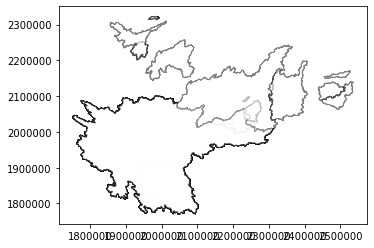

In [12]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt

r = Reader(**bassins[2])

fig = plt.figure()
ax = fig.gca() 
for poly in r.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2 ))

ax.axis('scaled')
plt.show()

In [ ]:
r = Reader(**bassins[0])

attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():
    geometry.append(row.shape.__geo_interface__)  
    attributes.append(dict(zip(field_names, row.record)))  

In [ ]:
#stations_on = stations[stations['Prov/Terr'] == 'ON']

In [ ]:
#stations_on.iloc[0]['Prov/Terr']

In [ ]:
#https://geo.weather.gc.ca/geomet/features/collections/hydrometric-stations/items
#http://dd.meteo.gc.ca/model_hrdps/continental/grib2/18/